<a href="https://colab.research.google.com/github/spretosg/PAREUS_PCA/blob/main/PAREUS_optimization_NSGA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial optimisation of protected areas and OECM to rech 30x30 target

This script is a V1.0 implementation that optimises spatial units to improve the existing protected area network in a study area. This routine will be used in the PAREUS project (WP4) taking data from WP2 & WP3. The spatial optimisation is based on a genetic evolutionary algorithm (NSGA3) including many optimisation targets (goals) and different constraints. The script will be the basis for a further implementation into an interactive application at a later stage. The script will cover the following core steps:


1.   Create a study area and planning units (PU) with a specific resolution as spatial data frame
2.   Sample three spatial variables for each PU, based on google earth engine data sets
3. Define and solve an optimization problem
4. Visualize the results

## 1. Study area an PU
We define a test study area and create a grid of planning units (PU). The planning units are the spatial entities that will be optimized towards different goals and constraints.

In [ ]:
#imports
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, Point # Polygon was imported correctly

# Step 1: Define the coordinates of the study area (example coordinates of Trondheim)
coords = [(10.05, 63.25),  # Southwest corner
    (10.5308, 63.25),  # Southeast corner
    (10.5308, 63.4589),  # Northeast corner
    (10.05, 63.4589),  # Northwest corner
    (10.05, 63.25)]

# Step 2: Create a polygon using shapely
study_area_polygon = Polygon(coords)

# Step 3: Generate a grid of points within the polygon
x_min, y_min, x_max, y_max = study_area_polygon.bounds
grid_spacing = 0.008  # Define the spacing between grid points ---tbd

x_coords = np.arange(x_min, x_max, grid_spacing)
y_coords = np.arange(y_min, y_max, grid_spacing)
grid_polygons = []
for i in range(len(x_coords)-1):
    for j in range(len(y_coords)-1):
        x1, y1 = x_coords[i], y_coords[j]
        x2, y2 = x_coords[i+1], y_coords[j+1]
        poly_coords = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
        grid_polygon = Polygon(poly_coords)
        if study_area_polygon.contains(grid_polygon):
            grid_polygons.append(grid_polygon)

# Step 4: Create a GeoDataFrame to store the grid polygons
grid_gdf = gpd.GeoDataFrame(geometry=grid_polygons, crs="EPSG:4326")



Map the study area

In [ ]:
import folium

center_point = grid_gdf.geometry.unary_union.centroid.coords[0][::-1] # reverse coordinates for folium

# Create a folium map centered on the selected units
m = folium.Map(location=center_point, zoom_start=10)
# Add the selected units to the map
folium.GeoJson(grid_gdf.geometry.to_crs(epsg=4326)).add_to(m)
m

## 2. Sample environmental variables

Hereinafter, we sample different environmental variables. These variables will be outputs from WP2 - WP4. In this test case we use the following variables from google earth engine and define it for the optimization problem:


*   Biodiversity integrity --> maximize (not used now)
*   Carbon storage potential --> maximize
*   Elevation --> minimize
*   Population density --> constraint (not used now)
*   Connectivity --> maximize
*   Area protected --> constraint







### 2.1 Check if in already protected areas
The WDPA polygons are used to check which PU's fall within already protected areas. User can decide wheather to include or exclude (lockout)

In [ ]:
import ee ## use earth engine
ee.Authenticate()
ee.Initialize(project='pareus')

In [ ]:


wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")



# Function to check for intersection
def check_intersection(geometry):
    # Convert GeoPandas geometry to GeoJSON
    geojson = geometry.__geo_interface__

    # Convert GeoJSON to Earth Engine geometry
    ee_geom = ee.Geometry(geojson)

    # Check for intersection with WDPA
    intersection = wdpa.filterBounds(ee_geom).size().getInfo()

    return intersection > 0

# Apply the function to each geometry in the GeoDataFrame
grid_gdf['intersects_wdpa'] = grid_gdf['geometry'].apply(check_intersection)
# Filter the GeoDataFrame to include only grid cells that do not intersect with protected areas
#grid_gdf_filtered = grid_gdf[grid_gdf['intersects_wdpa'] == False]



### 2.1 Sampling ee data sets to PU's

In [ ]:
import multiprocessing

elevation_data = ee.Image('USGS/GMTED2010_FULL')

# Define a function to sample elevation for each polygon
def sample_elevation(polygon):
    # Convert shapely polygon to Earth Engine geometry
    # Convert the list of tuples to a list of lists
    ee_polygon = ee.Geometry.Polygon([[list(coord) for coord in polygon.exterior.coords]])

    # Calculate the mean elevation within the polygon
    mean_elevation = elevation_data.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=ee_polygon,
        scale=100  # Adjust scale as needed
    ).get('be75')

    return mean_elevation.getInfo()

# Apply the sampling function to each polygon in the GeoDataFrame
#grid_gdf['mean_elevation'] = grid_gdf['geometry'].apply(sample_elevation)
# Create a pool of worker processes
pool = multiprocessing.Pool()

# Apply the sampling function to each polygon in parallel
grid_gdf['mean_eleva'] = pool.map(sample_elevation, grid_gdf['geometry'])

# Close the pool of worker processes
pool.close()
pool.join()



In [ ]:
## biodiversity

bdi_ic = ee.ImageCollection("projects/ebx-data/assets/earthblox/IO/BIOINTACT").mean()
#bdi_2017_20_comp = bdi_ic.mean()
#bdi_2017_comp = bdi_ic.filterDate('2017-01-01', '2017-12-31').mean()

# Define a function to sample bii for each polygon
def sample_bii(polygon):
    # Convert shapely polygon to Earth Engine geometry
    # Convert the list of tuples to a list of lists
    ee_polygon = ee.Geometry.Polygon([[list(coord) for coord in polygon.exterior.coords]])

    # Calculate the mean bii within the polygon
    mean_bii = bdi_ic.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=ee_polygon,
        scale=100  # Adjust scale as needed
    ).get('BioIntactness')

    return mean_bii.getInfo()

# Apply the sampling function to each polygon in the GeoDataFrame
#grid_gdf['mean_biodiversity'] = grid_gdf['geometry'].apply(sample_bii)
# Create a pool of worker processes
pool = multiprocessing.Pool()

# Apply the sampling function to each polygon in parallel
grid_gdf['mean_biodi'] = pool.map(sample_bii, grid_gdf['geometry'])

# Close the pool of worker processes
pool.close()
pool.join()

In [ ]:
## carbon density [CO t/ha]

co = ee.Image('WCMC/biomass_carbon_density/v1_0/2010')
# Define a function to sample carbon for each polygon
def sample_co(polygon):
    # Convert shapely polygon to Earth Engine geometry
    # Convert the list of tuples to a list of lists
    ee_polygon = ee.Geometry.Polygon([[list(coord) for coord in polygon.exterior.coords]])

    # Calculate the mean co within the polygon
    mean_co = co.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=ee_polygon,
        scale=100  # Adjust scale as needed
    ).get('carbon_tonnes_per_ha')

    return mean_co.getInfo()

# Apply the sampling function to each polygon in the GeoDataFrame
#grid_gdf['mean_co'] = grid_gdf['geometry'].apply(sample_co)
# Create a pool of worker processes
pool = multiprocessing.Pool()

# Apply the sampling function to each polygon in parallel
grid_gdf['mean_co'] = pool.map(sample_co, grid_gdf['geometry'])

# Close the pool of worker processes
pool.close()
pool.join()

In [ ]:
## normalize data
# Function to normalize a column between 0 and 1
def normalize_column(column):
    return (column - column.min()) / (column.max() - column.min())

# Normalize the selected columns
columns_to_normalize = ['mean_eleva', 'mean_biodi', 'mean_co']
for col in columns_to_normalize:
    grid_gdf[col] = normalize_column(grid_gdf[col])

Save the grid_gdf for further processing

In [ ]:
GCP_PROJECT_ID = 'pareus'
PROJECT_NUMBER = '863990074236 '

In [ ]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()


In [ ]:
BUCKET_NAME = 'colab_optim'

GCS_BUCKET = f'gs://{BUCKET_NAME}'
!gsutil mb -p $GCP_PROJECT_ID $GCS_BUCKET

Creating gs://colab_optim/...
ServiceException: 409 A Cloud Storage bucket named 'colab_optim' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [ ]:
#grid_gdf.to_file("grid_data.shp")
grid_gdf.to_file("grid_data.geojson", driver="GeoJSON")
!gcloud storage cp grid_data.geojson gs://colab_optim/

Copying file://grid_data.geojson to gs://colab_optim/grid_data.geojson


## 3. Define an optimization problem
Based on the sampled data, a spatial optimization problem will be defined (just a sample problem):


*   Minimize the elevation of the PU's to avoid remote areas in the mountains
*   Maximize the biodiversity intactness index
*   Maximize connectivity between PU's

Constraints:
*   Define a total km2 area that should be protected

The user can add a weight to the optimization goals to develop different scenarios.



*if steps 1 and 2 already done use this code:*

In [ ]:
GCP_PROJECT_ID = 'pareus'
PROJECT_NUMBER = '863990074236 '

import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

BUCKET_NAME = 'colab_optim'

GCS_BUCKET = f'gs://{BUCKET_NAME}'
!gsutil mb -p $GCP_PROJECT_ID $GCS_BUCKET

!gcloud storage cp gs://colab_optim/grid_data.geojson .
import geopandas as gpd




Creating gs://colab_optim/...
ServiceException: 409 A Cloud Storage bucket named 'colab_optim' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Copying gs://colab_optim/grid_data.geojson to file://./grid_data.geojson


In [ ]:
grid_gdf = gpd.read_file("grid_data.geojson")
#print(grid_gdf)

      intersects_wdpa  mean_eleva  mean_biodi   mean_co  \
0               False    0.160294    0.313310  0.155335   
1               False    0.117647    0.326545  0.086961   
2               False    0.095588    0.661873  0.061229   
3               False    0.092647         NaN  0.107547   
4               False    0.114706    0.578832  0.486454   
...               ...         ...         ...       ...   
1555            False    0.019118    0.317352  0.150924   
1556            False    0.000000    0.330990  0.090637   
1557            False    0.000000         NaN       NaN   
1558            False    0.000000         NaN       NaN   
1559            False    0.000000         NaN       NaN   

                                               geometry  
0     POLYGON ((10.05000 63.25000, 10.05800 63.25000...  
1     POLYGON ((10.05000 63.25800, 10.05800 63.25800...  
2     POLYGON ((10.05000 63.26600, 10.05800 63.26600...  
3     POLYGON ((10.05000 63.27400, 10.05800 63.27400...  
4

In [ ]:
#optim package pymoo
!pip install pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from shapely.ops import unary_union


Filter the grid if necessary

In [ ]:
def filter_grid(grid_gdf, include_wdpa):
    """Filters the grid based on intersection with WDPA.

    Args:
        grid_gdf: The GeoDataFrame containing the grid.
        include_wdpa: Boolean flag indicating whether to include
            (True) or exclude (False) areas intersecting with WDPA.

    Returns:
        The filtered GeoDataFrame.
    """

    if include_wdpa == True:
        return grid_gdf
    else:
        return grid_gdf[grid_gdf['intersects_wdpa'] == False]

# Example usage:
filtered_grid = filter_grid(grid_gdf, include_wdpa=False)



In [ ]:
# calculate the area for each grid cell
grid_gdf_projected = filtered_grid.to_crs('EPSG:3035')
filtered_grid['area'] = grid_gdf_projected.geometry.area/100000

## drop possible NaN (e.g. offshore in this case)
filtered_grid = filtered_grid.dropna()

## With connectivity

In [ ]:
class SpatialOptimizationProblem(Problem):
    def __init__(self, grid_gdf, min_area, max_area, w1, w2, w3, w4, n_obj):
        super().__init__(n_var=len(grid_gdf),
                         n_obj=n_obj,
                         n_ieq_constr=2,
                         xl=0,
                         xu=1,
                         type_var=int)
        self.features = grid_gdf
        self.min_area = min_area # Add min_area as an attribute
        self.max_area = max_area # Add min_area as an attribute
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4

    def _evaluate(self, x, out, *args, **kwargs):
        elevation = self.features['mean_eleva'].values
        biodiversity = self.features['mean_biodi'].values
        carbon = self.features['mean_co'].values
        area = self.features['area'].values

        # Objective 1: Minimize elevation
        f1 = self.w1 * np.sum(x * elevation, axis=1)

        # Objective 2: Maximize biodiversity
        f2 = self.w2 * -np.sum(x * biodiversity, axis=1)

        #Objective 3: Maximize carbon storage potential
        f3 = self.w3 * -np.sum(x * carbon, axis=1)

        # Objective 4: Maximize connectivity (was g2)
        f4 = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            selected_units = self.features.iloc[np.where(x[i] == 1)[0]]
            if not selected_units.empty:
                merged_geom = unary_union(selected_units.geometry)
                if hasattr(merged_geom, 'geoms'):
                    f3[i] = -len(selected_units) + len(merged_geom.geoms) # Minimize number of components
                else:
                    f3[i] = 0  # Single polygon, fully connected

        # Multiply the connectivity objective by its weight w4
        f4 = self.w4 * f4

        out["F"] = np.column_stack([f1, f2, f3, f4])

        # g1 area sum smaller than
        g1 = np.sum(x * area, axis=1)-self.max_area
        #g2 larger than 5km2
        g2 = self.min_area-np.sum(x * area, axis=1)

        out["G"] = [g1,g2]

## Without connectivity

In [ ]:
class SpatialOptimizationProblem(Problem):
    def __init__(self, grid_gdf, min_area, max_area, w1, w2, w3):
        super().__init__(n_var=len(grid_gdf),
                         n_obj=3,
                         n_ieq_constr=2,
                         xl=0,
                         xu=1,
                         type_var=int)
        self.features = grid_gdf
        self.min_area = min_area # Add min_area as an attribute
        self.max_area = max_area # Add min_area as an attribute
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def _evaluate(self, x, out, *args, **kwargs):
        elevation = self.features['mean_eleva'].values
        biodiversity = self.features['mean_biodi'].values
        carbon = self.features['mean_co'].values
        area = self.features['area'].values

        # Objective 1: Minimize elevation
        f1 = self.w1 * np.sum(x * elevation, axis=1)

        # Objective 2: Maximize biodiversity
        f2 = self.w2 * -np.sum(x * biodiversity, axis=1)

        #Objective 3: Maximize carbon storage potential
        f3 = self.w3 * -np.sum(x * carbon, axis=1)



        out["F"] = np.column_stack([f1, f2, f3])

        # g1 area sum smaller than 30
        g1 = np.sum(x * area, axis=1)-self.max_area
        #g2 greater than 5km2
        g2 = self.min_area-np.sum(x * area, axis=1)

        out["G"] = [g1,g2]

In [ ]:
min_area = 50 #km2
max_area = 300 #km2
n_obj = 3
## without connectivity
problem = SpatialOptimizationProblem(filtered_grid,min_area, max_area, 0.5,0.1,0.3)

## with connectivity
#problem = SpatialOptimizationProblem(filtered_grid,min_area, max_area, 0.5,0.1,0.3, 1, n_obj)



In [ ]:
#!pip install --upgrade pymoo  # Upgrade pymoo to the latest version

from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx  import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation # Import BitflipMutation
from pymoo.core.callback import Callback
from pymoo.indicators.hv import HV

ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=12)

algorithm = NSGA3(
    pop_size=len(ref_dirs)+1,
    n_offsprings=10,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),  # Use binary crossover
    mutation=BitflipMutation(),    # Use bitflip mutation
    eliminate_duplicates=True,
    ref_dirs=ref_dirs
)

# Callback to track HV
class HVCallback(Callback):
    def __init__(self, ref_point):
        super().__init__()
        self.hv = HV(ref_point=ref_point)
        self.hv_values = []

    def notify(self, algorithm):
        F = algorithm.pop.get("F")
        hv = self.hv.do(F)
        self.hv_values.append(hv)

# Define a reference point for hypervolume calculation
ref_point = np.array([1, 1, 1])
hv_callback = HVCallback(ref_point)

In [ ]:
## optimization follows here:
from pymoo.termination import get_termination
import pandas as pd

termination = get_termination("n_gen", 10000)
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               n_jobs=-1,  # Utilize all available cores
               save_history=True,
               callback=hv_callback,
               verbose=True)



some stats

In [ ]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population
hist = res.history
for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

At least one feasible solution in Generation 1733 after 17422 evaluations.


Whole population feasible in Generation 1768 after 17772 evaluations.


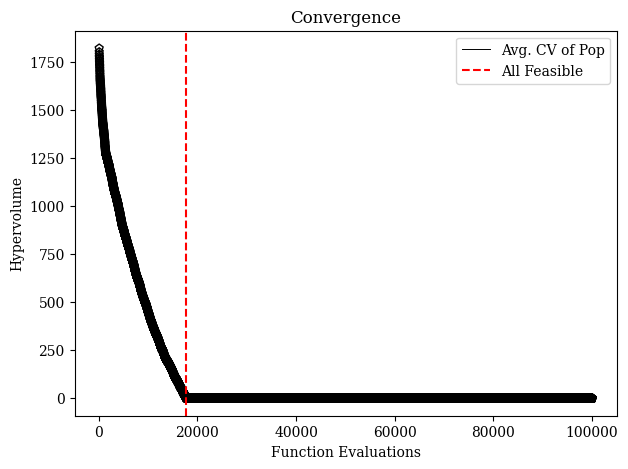

In [ ]:
# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

In [ ]:
F = res.opt.get("F")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

print(approx_nadir)

[ 7.03235294 -4.23294307 -9.73769843]


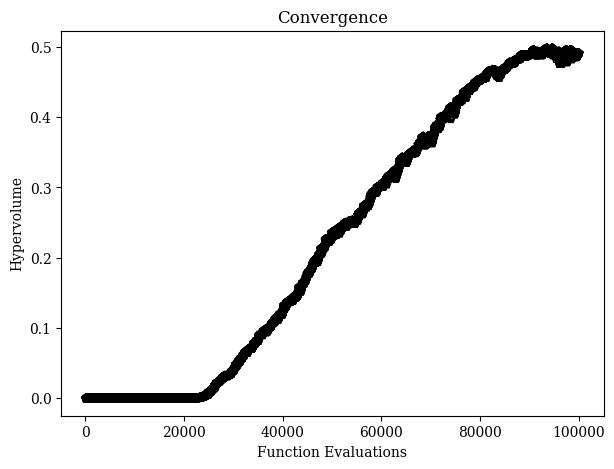

In [ ]:
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array([1, 1, 1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()


Count how often each individual is within the optimal solution

In [ ]:
unit_counts = {}
for i in range(len(filtered_grid)):
    unit_counts[i] = 0

# Iterate through the optimal solutions
for solution in res.X:
    # Get indices of selected units (assuming binary solutions)
    selected_indices = np.where(solution == 1)[0]
    # Increment counts for selected units
    for idx in selected_indices:
        unit_counts[idx] += 1

# Print the counts
#for unit_id, count in unit_counts.items():
#    print(f"Planning Unit {unit_id}: {count} occurrences")

count_series = pd.Series({k: v / len(res.G) for k, v in unit_counts.items()}, name='rel_occ_paropt1')
filtered_grid = filtered_grid.reset_index(drop=True)  # Drop the old index
filtered_grid = filtered_grid.join(count_series)

## 4. Visualize the optimization results

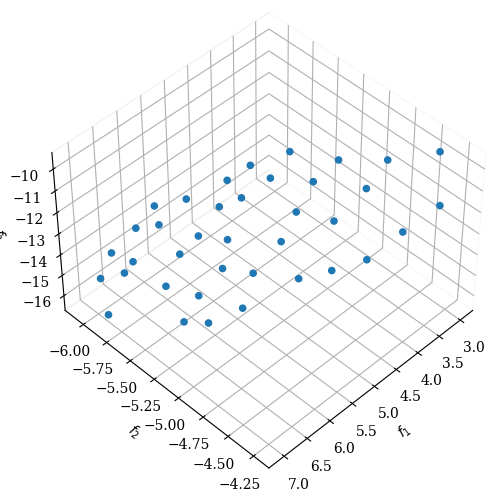

In [ ]:
plot = Scatter()
plot.add(res.F)
#print(res.F)
plot.show()

Here single optimal solutions of each iteration can be visualized. Adjust the index manually.

In [ ]:
print(res.G)

### Single optimal solution based on optim index

In [ ]:
#index = 110 # which of the iterations to display
# Iterate through each solution in the population
#for solution in res.history[index].pop.get("X"):

for solution in res.X:
    # Get the indices of the selected features

    selected_indices = np.where(solution ==1)[0]

    # Filter the features GeoDataFrame
    selected_features = filtered_grid.iloc[selected_indices]

    # Print or process the selected features for this solution
#print(selected_features)
center_point = selected_features.geometry.unary_union.centroid.coords[0][::-1] # reverse coordinates for folium

# Create a folium map centered on the selected units
m = folium.Map(location=center_point, zoom_start=10)

# Add the selected units to the map
folium.GeoJson(selected_features.geometry.to_crs(epsg=4326)).add_to(m)

print(sum(selected_features['area']))
print(len(selected_features))
# Display the map
m


299.9283347291338
84


In [ ]:
optimal_solutions = res.opt.get("X")
print(len(optimal_solutions))
#the first optimal solution:
individual_solution = optimal_solutions[4]
print(individual_solution)

selected_indices = np.where(individual_solution ==1)[0]
print(len(selected_indices))


    # Filter the features GeoDataFrame
selected_features = filtered_grid.iloc[selected_indices]
print(sum(selected_features['area']))

    # Print or process the selected features for this solution
#print(selected_features)
center_point = selected_features.geometry.unary_union.centroid.coords[0][::-1] # reverse coordinates for folium

# Create a folium map centered on the selected units
m = folium.Map(location=center_point, zoom_start=10)

# Add the selected units to the map
folium.GeoJson(selected_features.geometry.to_crs(epsg=4326)).add_to(m)



m

38
[False False False ... False False False]
84
299.9421815413667


### Importance of areas
The hgiher the importance value, the more frequent the PU is present in one of the pareto optimal solutions.

In [ ]:
# prompt: take the rel_occ_paropt3 col of the grid_gdf and visualize it on the map with a color

import folium

# Define the color map
color_map = 'YlGn'

# Set the threshold
threshold = 0.5  # Replace with your desired threshold value

# Filter the GeoDataFrame
filtered_gdf = filtered_grid[filtered_grid['rel_occ_paropt1'] > threshold]

# Create a new column for the color values
filtered_gdf['color_value'] = filtered_gdf['rel_occ_paropt1']

# Create a map centered on the study area
center_point = filtered_gdf.geometry.unary_union.centroid.coords[0][::-1]
m = folium.Map(location=center_point, zoom_start=10)

# Reset the index of the GeoDataFrame to create an 'index' column
filtered_gdf = filtered_gdf.reset_index()

# Add a choropleth layer to the map
folium.Choropleth(
    geo_data=filtered_gdf.to_json(),
    data=filtered_gdf,
    columns=['index', 'color_value'],
    key_on='feature.properties.index',
    fill_color=color_map,
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Relative occurence in pareto solutions'
).add_to(m)

# Display the map
m
